![系统流程](./images/系统总体流程图.png)

# 前期准备

## 相关参数

In [1]:
from pathlib import Path

In [2]:
config = {
    "seed": 519,
    "vectorizer_file": "vectorizer.json",
    "model_state_file": "model.pth",
    "save_dir": Path.cwd() / "experiments" / "main" / "1558276575_74f6ab40-7a43-11e9-8b2b-0242ac1c0002",
    # ODEnet
    "input_dim": 3,
    "state_dim": 64,
    "tol": 1e-5,
    # GRU
    "cutoff": 25,
    "num_layers": 1,
    "embedding_dim": 100,
    "kernels": [1, 3],
    "num_filters": 100,
    "rnn_hidden_dim": 64,
    "hidden_dim": 36,
    "dropout_p": 0.5,
    "bidirectional": False,
}

## 特征提取准备

### Sandbox类

* vmrun_path：vmrun.exe路径
* vmx_path：虚拟机.vmx路径
* vm_snapshot：虚拟机快照名real
* vm_user：虚拟机用户名
* vm_pass：虚拟机密码
* script_path：虚拟机内Python脚本路径
* python_path：虚拟机内Python路径
* malware_path：虚拟机内暂存样本路径
* timeout：运行脚本超时时间

In [3]:
from my_sandbox.get_features import Sandbox

In [4]:
sb = Sandbox(
        vmrun_path=r"E:\VMware\vmrun.exe",
        vmx_path=r"D:\虚拟机\Win10\Windows 10 x64.vmx",
        vm_snapshot="real",
        vm_user="msi",
        vm_pass="123456",
        script_path=r"C:\Users\msi\Desktop\my_sandbox_script.py",
        python_path=r"C:\Users\msi\AppData\Local\Programs\Python\Python35\python.exe",
        malware_path=r"C:\Malware",
        timeout=10)

## 预处理准备

In [5]:
from pre_data.preprocess import Preproce

In [6]:
pp = Preproce()

## 加载向量器

In [7]:
import json
from Datasets.datasets import Vectorizer

In [8]:
vectorizer_filepath = config['save_dir'] / config['vectorizer_file']
with vectorizer_filepath.open() as fp:
    vectorizer = Vectorizer.from_serializable(json.load(fp))

In [9]:
print(vectorizer.image_vocab)
print(vectorizer.ins_word_vocab)
print(vectorizer.ins_char_vocab)
print(vectorizer.packer_vocab)

<IMG_SequenceVocabulary(train_means: [128.47567749023438, 93.32111358642578, 38.726646423339844], train_stds: [59.69920349121094, 89.16869354248047, 61.76454162597656]>
<INS_SequenceVocabulary(size=106)>
<INS_SequenceVocabulary(size=34)>
<Vocabulary(size=7)>


## 加载模型

In [10]:
from main_train import MainModel
import torch

In [11]:
model = MainModel(
    input_dim=config["input_dim"],
    state_dim=config["state_dim"],
    tol=config["tol"],
    embedding_dim=config["embedding_dim"],
    num_word_embeddings=len(vectorizer.ins_word_vocab),
    num_char_embeddings=len(vectorizer.ins_char_vocab),
    kernels=config["kernels"],
    num_input_channels=config["embedding_dim"],
    num_output_channels=config["num_filters"],
    rnn_hidden_dim=config["rnn_hidden_dim"],
    hidden_dim=config["hidden_dim"],
    output_dim=len(vectorizer.packer_vocab),
    num_layers=config["num_layers"],
    bidirectional=config["bidirectional"],
    dropout_p=config["dropout_p"],
    word_padding_idx=vectorizer.ins_word_vocab.mask_index,
    char_padding_idx=vectorizer.ins_char_vocab.mask_index)

model.load_state_dict(torch.load(config['save_dir'] / config['model_state_file']))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [12]:
model = model.to("cpu")
# print(model.named_modules)

## 预测类

In [13]:
class Inference(object):
    def __init__(self, model, vectorizer):
        self.model = model
        self.vectorizer = vectorizer

    def predict_packer(self, image, ins):
        # 向量化
        image_vector, ins_word_vector, ins_char_vector, ins_length = self.vectorizer.vectorize(image, ins)
        
        image_vector = torch.FloatTensor(image_vector).unsqueeze(0)
        ins_word_vector = torch.tensor(ins_word_vector).unsqueeze(0)
        ins_char_vector = torch.tensor(ins_char_vector).unsqueeze(0)
        ins_length = torch.tensor([ins_length]).long()

        # 预测
        self.model.eval()
        attn_scores, y_pred = self.model(x_img=image_vector,
                                         x_word=ins_word_vector,
                                         x_char=ins_char_vector,
                                         x_lengths=ins_length,
                                         device="cpu",
                                         apply_softmax=True)

        # 取概率最大
        y_prob, indices = y_pred.max(dim=1)
        index = indices.item()

        # 预测壳类型
        packer = vectorizer.packer_vocab.lookup_index(index)
        probability = y_prob.item()
        return {'packer': packer, 'probability': probability, 
                'attn_scores': attn_scores}

    def predict_top_k(self, image, ins, k):
        # 向量化
        image_vector, ins_word_vector, ins_char_vector, ins_length = self.vectorizer.vectorize(image, ins)
        
        image_vector = torch.FloatTensor(image_vector).unsqueeze(0)
        ins_word_vector = torch.tensor(ins_word_vector).unsqueeze(0)
        ins_char_vector = torch.tensor(ins_char_vector).unsqueeze(0)
        ins_length = torch.tensor([ins_length]).long()

         # 预测
        self.model.eval()
        _, y_pred = self.model(x_img=image_vector,
                               x_word=ins_word_vector,
                               x_char=ins_char_vector,
                               x_lengths=ins_length,
                               device="cpu",
                               apply_softmax=True)
        
        # Top k
        y_prob, indices = torch.topk(y_pred, k=k)
        probabilities = y_prob.detach().numpy()[0]
        indices = indices.detach().numpy()[0]

        # 结果
        results = []
        for probability, index in zip(probabilities, indices):
            packer = self.vectorizer.packer_vocab.lookup_index(index)
            results.append({'packer': packer, 'probability': probability})

        return results

In [14]:
inference = Inference(model=model, vectorizer=vectorizer)

# 开始

## 输入

In [15]:
input_path = r"C:\Users\msi\Desktop\aspack变形.exe"

## 特征提取

![特征提取](./images/特征提取模块.png)

In [17]:
# 输入要检测的文件路径，得到特征
features = sb.get_features(input_path, no_gui=False, stop=True)

--> revertToSnapshot
 
--> start
 
--> copyFileFromHostToGuest
 
--> runProgramInGuest
 
--> copyFileFromGuestToHost
 
--> stop
 
--> get features
--> completed!


In [18]:
features.split("\n")[0]

'0x0044d001 9c --> pushfd '

In [19]:
features2 = sb.get_features(r"C:\Users\msi\Desktop\2019_3_28.kdbx", no_gui=False, stop=True)

--> revertToSnapshot
 
--> start
 
--> copyFileFromHostToGuest
 
--> runProgramInGuest
 
--> copyFileFromGuestToHost
 
--> stop
 
--> get features
--> completed!


## 预处理

![预处理模块](./images/预处理模块.png)

In [21]:
data_dict = pp.preprocess(features)

In [20]:
# 异常
_ = pp.preprocess(features2)
print(_)

get error! this is not PE
None


In [22]:
img = data_dict['image'][0]
ins = data_dict['ins'][0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


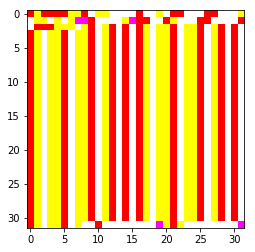

In [23]:
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()

In [24]:
img[0,0,:]

array([156.,   0.,   0.], dtype=float32)

In [25]:
ins

'pushfd call pop inc push ret jmp call pop mov add sub cmp mov jnz lea push call mov mov lea push push call mov lea push push call mov lea jmp mov or jz lea cmp jz push push push push call mov mov add push push push push call mov push mov add push push push push call mov sub lea push call push push push mov xor xor lea mov push call call pop sub ret mov pop mov add shl add inc cmp jb mov push call call pop sub ret mov pop mov add shl add inc cmp jb mov push call call pop sub ret mov pop mov add shl add inc cmp jb mov push call call pop sub ret mov pop mov add shl add inc cmp jb mov push call call pop sub ret mov pop mov add shl add inc cmp jb mov push call call pop sub ret mov pop mov add shl add inc cmp jb mov push call call pop sub ret mov pop mov add shl add inc cmp jb mov push call call pop sub ret mov pop mov add shl add inc cmp jb mov push call call pop sub ret mov pop mov add shl add inc cmp jb mov push call call pop sub ret mov pop mov add shl add inc cmp jb mov push call call 

## 分类与输出

![分类模型](./images/分类模型.png)

### 预测

In [26]:
prediction = inference.predict_packer(img, ins)
print("{} → {} (p={:0.2f})".format(input_path, prediction['packer'], 
                                    prediction['probability']))

C:\Users\msi\Desktop\aspack变形.exe → ASPack (p=1.00)


### top-k

In [27]:
# Top-k
top_k = inference.predict_top_k(img, ins, k=len(vectorizer.packer_vocab))
print ("{}: ".format(input_path))
for result in top_k:
    print("{} (p={:0.2f})".format(result['packer'], 
                                  result['probability']))

C:\Users\msi\Desktop\aspack变形.exe: 
ASPack (p=1.00)
PeSpin (p=0.00)
Molebox (p=0.00)
Normal (p=0.00)
NsPack (p=0.00)
PECompact (p=0.00)
UPX (p=0.00)
